In [13]:
!pip install duckduckgo_search

In [14]:
import PIL
import cv2
from PIL import Image
from IPython.display import Image, display
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from fastai.vision.all import unet_learner
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from fastai.metrics import mae
from fastai.metrics import mse

import os
import torch.nn.functional as F

In [15]:
from google.colab import drive

In [17]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Collect Data

In [18]:
ddgs = DDGS()

def search_images(term, max_images=50):
  print(f"Searching for '{term}'")
  return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')

In [19]:
def convert_to_greyscale(input_filename, output_filename):
    img = Image.open(input_filename).convert('L')
    img.save(output_filename)

Searching for 'elliott erwitt photography paris'


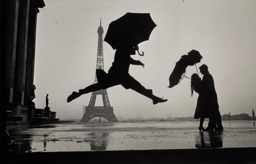

In [20]:
urls = search_images('elliott erwitt photography paris', max_images=1)
dest = 'Elliot Erwit.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

Searching for 'greyscale image of summer paris'


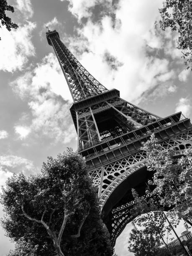

In [21]:
urls = search_images('greyscale image of summer paris', max_images=1)
dest = 'Paris in Grey.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

In [22]:
path = Path('/content/drive/MyDrive/Colorizer/training images')

In [24]:
def list_filenames(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

In [25]:
directory = '/content/drive/MyDrive/Colorizer/training images'
filenames = list_filenames(directory)

In [26]:
for input_filename in filenames:
    name, ext = input_filename.rsplit('.', 1)
    if (ext == 'jpg' or ext == 'png'):
      output_filename = f"{name}_greyscale.{ext}"
      if not os.path.exists(output_filename) and not 'greyscale' in input_filename:
            convert_to_greyscale(input_filename, output_filename)

# Train Model

In [27]:
def get_greyscale_image_files(path):
    return [p for p in get_image_files(path) if 'greyscale' in p.name]

def get_corresponding_color_image(greyscale_path):
    return greyscale_path.with_name(greyscale_path.name.replace('_greyscale', ''))

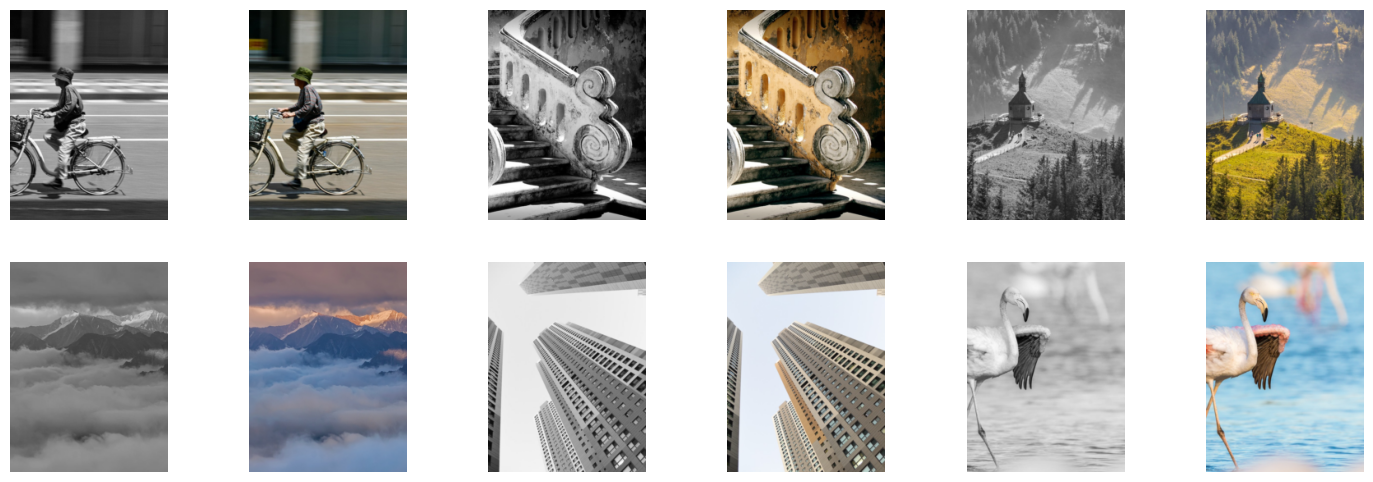

In [28]:
## taking out ResizeMethod.Pad
for method in [ResizeMethod.Crop, RandomResizedCrop(128)]:
  item_tfms = [Resize((256,192), method=method)]

dls = DataBlock(
    blocks = (ImageBlock, ImageBlock), # input, output
    get_items = get_greyscale_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # split the data, randomly put aside testing data
    get_y = get_corresponding_color_image,
    item_tfms = item_tfms
).dataloaders(path, bs=20)

dls.show_batch(max_n=6)

In [29]:
# resnet18, resnet34, resnet50, resnet101, resnet152
learn = unet_learner(dls, resnet18, metrics=[mse], loss_func=MSELossFlat(), n_out=3)
learn.fine_tune(30)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 42.8MB/s]


epoch,train_loss,valid_loss,mse,time
0,0.365506,0.247216,0.247216,00:45


epoch,train_loss,valid_loss,mse,time
0,0.219942,0.223644,0.223644,00:44
1,0.201422,0.200801,0.200801,00:42
2,0.189837,0.203523,0.203523,00:44
3,0.184717,0.195562,0.195562,00:44
4,0.181570,0.196795,0.196795,00:46
5,0.179611,0.232855,0.232855,00:43
6,0.178047,0.181583,0.181583,00:44
7,0.173879,0.193071,0.193071,00:45
8,0.163845,0.176076,0.176076,00:45
9,0.158177,0.180899,0.180899,00:45


# Use the model

In [30]:
img = PILImage.create('Paris in Grey.jpg')

In [31]:
pred, _, _ = learn.predict(img)

In [32]:
print(pred)

TensorImage([[[ 13,  21,   2,  ..., 145, 162, 160],
              [  1,  23,  11,  ..., 110, 109, 102],
              [  7,  30,  42,  ...,  96,  46,  57],
              ...,
              [194, 196, 194,  ...,  46,  35,  15],
              [192, 193, 189,  ...,  91,  52,  39],
              [183, 187, 191,  ...,  58,  49,  40]],

             [[ 23,  26,  14,  ..., 145, 162, 156],
              [  7,  25,  19,  ..., 116, 109,  93],
              [ 10,  22,  37,  ..., 102,  49,  56],
              ...,
              [178, 179, 180,  ...,  43,  29,  14],
              [172, 172, 172,  ...,  84,  47,  36],
              [166, 169, 174,  ...,  55,  49,  38]],

             [[ 25,  26,  15,  ..., 143, 156, 152],
              [ 16,  29,  24,  ..., 111, 105,  91],
              [ 26,  34,  45,  ..., 104,  53,  58],
              ...,
              [152, 156, 156,  ...,  40,  27,  10],
              [154, 151, 150,  ...,  81,  42,  30],
              [149, 150, 156,  ...,  48,  39,  33]]])


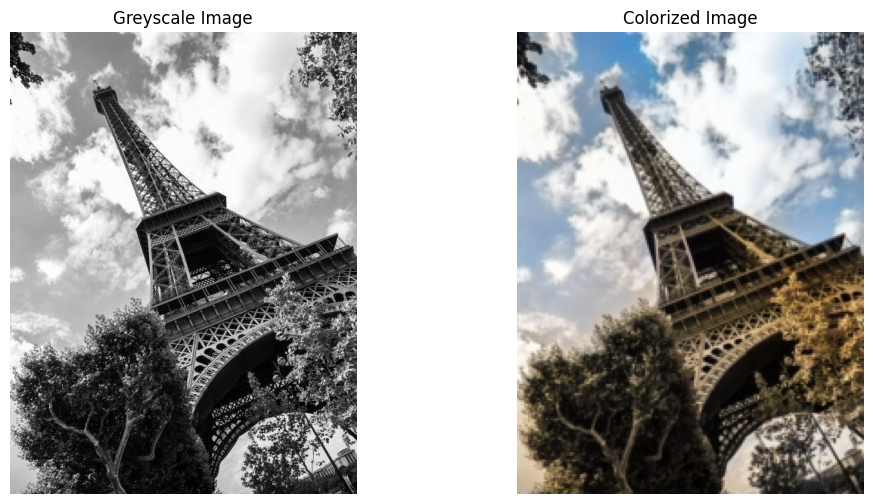

In [33]:
# Convert the prediction to an image
colorized_image = Image.fromarray(pred.numpy().transpose(1, 2, 0).astype(np.uint8))

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Greyscale Image')
ax[0].axis('off')

ax[1].imshow(colorized_image)
ax[1].set_title('Colorized Image')
ax[1].axis('off')

plt.show()

In [34]:
img_elliot = PILImage.create('Elliot Erwit.jpg')

In [35]:
pred_elliot, _, _ = learn.predict(img_elliot)

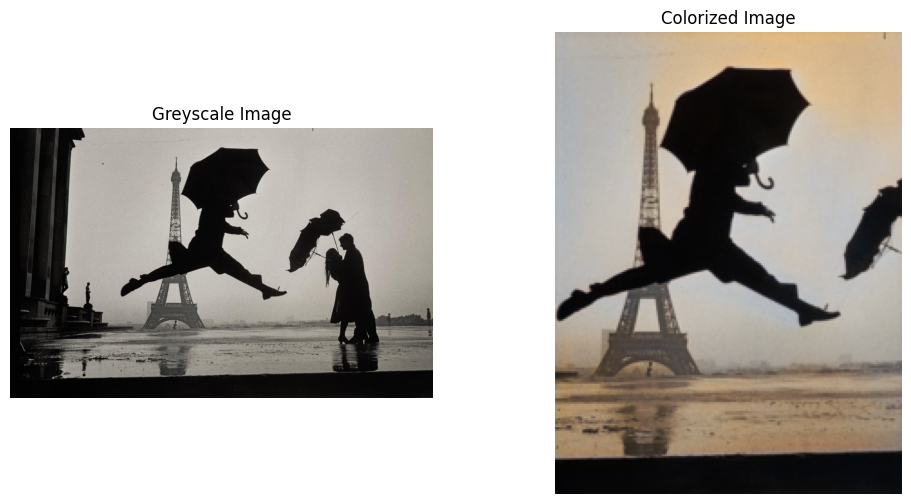

In [36]:
# Convert the prediction to an image
colorized_image = Image.fromarray(pred_elliot.numpy().transpose(1, 2, 0).astype(np.uint8))

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_elliot, cmap='gray')
ax[0].set_title('Greyscale Image')
ax[0].axis('off')

ax[1].imshow(colorized_image)
ax[1].set_title('Colorized Image')
ax[1].axis('off')

plt.show()